# Handwritten digits recognition

In [155]:
# Import keras library.
from keras import *
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers.noise import GaussianDropout
from keras.layers import Flatten, AveragePooling2D, UpSampling2D, Conv2D

# Import the numpy library for matrix manipulations etc.
from numpy import *

# Set up the graphics
import matplotlib.pyplot as plt
%matplotlib inline

# Set up a random number generator
rng = random.RandomState(23455)

import time

In [156]:

# Libraries
# Standard library
import pickle
import gzip

def load_data():
        f = gzip.open('mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f,encoding='bytes')
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    
    global training_inputs, training_results
    global validation_inputs, validation_results
    global test_inputs, test_results
    global num_samples, numpixels, num_test_samples
    
    tr_d, va_d, te_d = load_data()
    
    num_samples=len(tr_d[0])
    training_inputs=zeros([num_samples,numpixels])
    training_results=zeros([num_samples,10])    
    for j in range(num_samples):
        training_inputs[j,:] = reshape(tr_d[0][j], (numpixels))
        training_results[j,:] = vectorized_result(tr_d[1][j])

    num_test_samples=len(te_d[0])
    test_inputs=zeros([num_test_samples,numpixels])
    test_results=zeros([num_test_samples,10])    
    for j in range(num_test_samples):
        test_inputs[j,:] = reshape(te_d[0][j], (numpixels))
        test_results[j,:] = vectorized_result(te_d[1][j])

def make_conv_shape():
    global training_inputs, test_inputs
    global num_samples, num_test_samples
    global M
    
    training_inputs=reshape(training_inputs,[num_samples,M,M,1])[:,::-1,:,:]
    test_inputs=reshape(test_inputs,[num_test_samples,M,M,1])[:,::-1,:,:]
    
    
def vectorized_result(j):
    e = zeros((10))
    e[j] = 1.0
    return e
# above steps are for loading data 

In [157]:
# initialize the convolutional network
def init_net_conv_twolayer():
    global net, numpixels
    net = Sequential()
    # here take 8 filters and 5X5 kernal. 
    net.add(Conv2D(input_shape=(M,M,1), filters=8, kernel_size=[5,5],activation='relu',padding='same'))
    net.add(AveragePooling2D(pool_size=2))
    net.add(Conv2D(filters=8, kernel_size=[5,5],activation='relu',padding='same'))    
    net.add(AveragePooling2D(pool_size=2))
    net.add(Flatten())
    net.add(Dense(10, activation='softmax'))
    net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [158]:
# initialize the convolutional network
def init_net_conv_twolayer_dropout():
    global net, numpixels
    net = Sequential()
    net.add(GaussianDropout(input_shape=(M,M,1), rate=0.1))
    net.add(Conv2D(filters=8, kernel_size=[5,5],activation='relu',padding='same'))
    net.add(AveragePooling2D(pool_size=2))
    net.add(Conv2D(filters=8, kernel_size=[5,5],activation='relu',padding='same'))    
    net.add(AveragePooling2D(pool_size=2))
    net.add(Flatten())
    net.add(Dense(10, activation='softmax'))
    net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [159]:
# initialize the convolutional network
def init_net_conv_simple():
    global net, numpixels, M
    net = Sequential()
    net.add(Conv2D(input_shape=(M,M,1), filters=7, kernel_size=[5,5],activation='relu',padding='same'))
    net.add(AveragePooling2D(pool_size=4))
    net.add(Flatten())
    net.add(Dense(10, activation='softmax'))
    net.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1.0), metrics=['categorical_accuracy'])

In [160]:
def test_on(start,stop,dontprint=False):
    global test_inputs, test_results
    global net, predictions_probs, predictions, true_labels
    
    predictions_probs=net.predict_on_batch(test_inputs[start:stop,:])
    predictions=argmax(predictions_probs,axis=1)
    if dontprint==False:
        print("Predictions: ", predictions)
    true_labels=argmax(test_results[start:stop,:], axis=1)
    if dontprint==False:
        print("True labels: ", true_labels)
# calculation of prediction probabilities 
# compare them with labled data

In [161]:
def display_image(which):
    global test_inputs
    
    plt.imshow(test_inputs[which,:,:,0],interpolation='nearest', cmap='binary', origin='lower')
    plt.show()

In [162]:
def display_mistakes(maxnum):
    global test_inputs, rest_results, num_test_samples
    global true_labels, predictions, predictions_probs
    
    test_on(0,num_test_samples,dontprint=True)
    which=where(true_labels!=predictions)[0]
    for j in which:
        if j<maxnum:
            display_image(j)
            print("True ", true_labels[j], " - Predicted ", predictions[j], " with prob. ", predictions_probs[j,predictions[j]])
        

In [163]:
def rescale_image(img):
    mn=img.min()
    mx=img.max()
    return((img-mn)/(mx-mn+1e-10))

def display_filters(which_layer):
    global BigImage
    
    the_layers=net.layers
    filters=the_layers[which_layer].get_weights()[0]
    s=shape(filters)
    MX=s[0]
    MY=s[1]
    num_in=s[2] # number of input channels
    num_out=s[3] # number of output channels
    BigImage=zeros([num_in*(MX+1),num_out*(MY+1)])
    BigImage[:,:]=1.0
    for j_in in range(num_in):
        for j_out in range(num_out):
            BigImage[j_in*(MX+1):(j_in+1)*(MX+1)-1,j_out*(MY+1):(j_out+1)*(MY+1)-1]=rescale_image(filters[:,:,j_in,j_out])
    plt.imshow(BigImage,origin='lower',interpolation='nearest',cmap='binary')
    plt.axis('off')
    plt.show()

## Test out things

In [164]:
numpixels=784
M=28 # 28x28 is 784
load_data_wrapper() # load all the MNIST images

In [165]:
make_conv_shape() # convert date to shape needed for conv (28x28)

In [166]:
shape(training_inputs)

(50000, 28, 28, 1)

In [167]:
init_net_conv_twolayer_dropout()

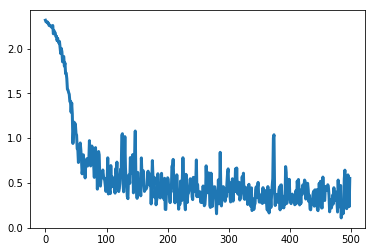

In [168]:
batchsize=100
batches=int(num_samples/batchsize)-1
costs=zeros(batches)
for j in range(batches):
    costs[j]=net.train_on_batch(training_inputs[j*batchsize:(j+1)*batchsize,:,:,:], training_results[j*batchsize:(j+1)*batchsize,:])[0]
plt.plot(costs,linewidth=3)
plt.show()

In [169]:
history=net.fit(training_inputs,training_results,batch_size=100,epochs=10,validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 17s 388us/step - loss: 0.2563 - categorical_accuracy: 0.9253 - val_loss: 0.2052 - val_categorical_accuracy: 0.9354
Epoch 2/10
45000/45000 [==============================] - 17s 376us/step - loss: 0.1707 - categorical_accuracy: 0.9500 - val_loss: 0.1596 - val_categorical_accuracy: 0.9478
Epoch 3/10
45000/45000 [==============================] - 17s 376us/step - loss: 0.1305 - categorical_accuracy: 0.9618 - val_loss: 0.1266 - val_categorical_accuracy: 0.9600
Epoch 4/10
45000/45000 [==============================] - 17s 378us/step - loss: 0.1081 - categorical_accuracy: 0.9686 - val_loss: 0.1180 - val_categorical_accuracy: 0.9624
Epoch 5/10
45000/45000 [==============================] - 17s 378us/step - loss: 0.0951 - categorical_accuracy: 0.9721 - val_loss: 0.1169 - val_categorical_accuracy: 0.9626
Epoch 6/10
45000/45000 [==============================] - 17s 382us/step - loss: 0.085

In [170]:
num_test_samples

10000

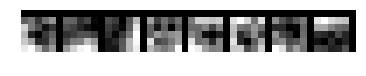

In [171]:
display_filters(1)

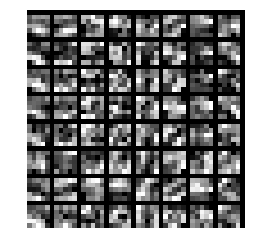

In [172]:
display_filters(3)

In [174]:
# see which fraction of the test samples is classified incorrectly
test_on(0,num_test_samples,dontprint=True)
which=where(true_labels!=predictions)[0]
print(len(which)/num_test_samples)

0.0162


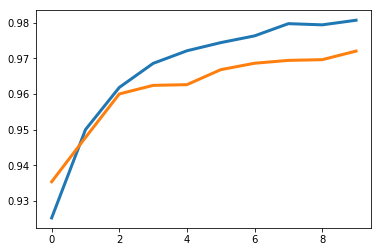

In [175]:
fig=plt.figure()
plt.plot(history.history['categorical_accuracy'], linewidth=3)
plt.plot(history.history['val_categorical_accuracy'], linewidth=3)
plt.show()
fig.savefig("Handwritten_MNIST_Conv_simple_Accuracy.pdf")
fig.savefig("Handwritten_MNIST_Conv_twolayer_Accuracy.pdf")

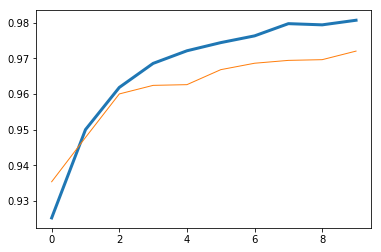

In [176]:
fig=plt.figure()
plt.plot(history.history['categorical_accuracy'], linewidth=3)
plt.plot(history.history['val_categorical_accuracy'], linewidth=1)
plt.show()
fig.savefig("Handwritten_MNIST_Conv_simple_Accuracy.pdf")
fig.savefig("Handwritten_MNIST_Conv_twolayer_Accuracy.pdf")

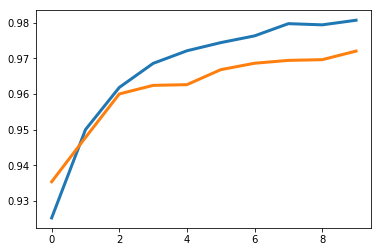

In [177]:
fig=plt.figure()
plt.plot(history.history['categorical_accuracy'], linewidth=3)
plt.plot(history.history['val_categorical_accuracy'], linewidth=3)
plt.show()
fig.savefig("Handwritten_MNIST_Conv_simple_Accuracy.pdf")
fig.savefig("Handwritten_MNIST_Conv_twolayer_Adam_Accuracy.pdf")

In [178]:
display_mistakes(200)

In [179]:
test_on(0,20)

Predictions:  [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
True labels:  [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


In [180]:
print(predictions_probs[8,:]) # prediction probabilities

[1.5592619e-10 8.4809757e-14 2.0809032e-10 7.0900633e-08 3.1666787e-11
 9.9974066e-01 2.4722255e-04 7.2878781e-10 1.1918378e-05 1.2656267e-07]


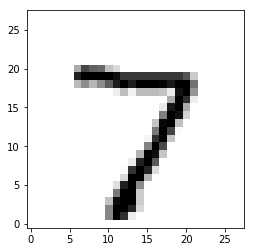

In [181]:
display_image(0)

In [182]:
short_inputs=training_inputs[0:200]
short_results=training_results[0:200]

# Misc

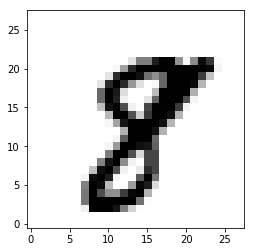

In [183]:
plt.imshow(training_inputs[55,:,:,0],cmap='binary',origin='lower',interpolation='nearest')
plt.show()